In [3]:
# Imports and Setup
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import DenseNet121_Weights
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# Define emotion labels and number of classes
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Custom Dataset class to handle loading and transforming images
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load and split data into training and validation sets
train_dir = 'data/train'
file_names = []
labels = []

for label, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(label)

train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.2, random_state=42)


In [6]:
# Define data augmentation and transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomAdjustSharpness(2),
    transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = EmotionDataset(train_files, train_labels, transform=transform_train)
val_dataset = EmotionDataset(val_files, val_labels, transform=transform_val)

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


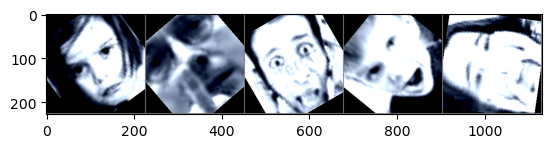

In [7]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize a batch of images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Function to get a batch of images from the dataloader
def show_augmented_images(data_loader, num_images=5):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_images]
    labels = labels[:num_images]
    imshow(torchvision.utils.make_grid(images))

# Create a DataLoader with a small batch size to visualize data augmentation
visualization_dl = DataLoader(train_dataset, batch_size=5, shuffle=True)

# Show augmented images
show_augmented_images(visualization_dl)


In [8]:
# Define the model with modified classifier
def densenet121_extended_model():
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )
    return model

# Instantiate the model and move to device
model = densenet121_extended_model()
model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
# Define the training function
def train(model, train_dl, val_dl, epochs, optimizer, loss_func, device):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dl.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        val_loss = running_val_loss / len(val_dl.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct / len(val_dl.dataset)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses

Epoch [1/20], Train Loss: 1.5258, Val Loss: 1.3304, Val Accuracy: 0.4385
Epoch [2/20], Train Loss: 1.1616, Val Loss: 0.9144, Val Accuracy: 0.6493
Epoch [3/20], Train Loss: 0.8952, Val Loss: 0.8000, Val Accuracy: 0.6926
Epoch [4/20], Train Loss: 0.7646, Val Loss: 0.7226, Val Accuracy: 0.7360
Epoch [5/20], Train Loss: 0.6620, Val Loss: 0.6333, Val Accuracy: 0.7711
Epoch [6/20], Train Loss: 0.6033, Val Loss: 0.6386, Val Accuracy: 0.7706
Epoch [7/20], Train Loss: 0.5628, Val Loss: 0.6171, Val Accuracy: 0.7755
Epoch [8/20], Train Loss: 0.5100, Val Loss: 0.6019, Val Accuracy: 0.7821
Epoch [9/20], Train Loss: 0.4698, Val Loss: 0.5678, Val Accuracy: 0.7947
Epoch [10/20], Train Loss: 0.4383, Val Loss: 0.6458, Val Accuracy: 0.7662
Epoch [11/20], Train Loss: 0.4031, Val Loss: 0.5973, Val Accuracy: 0.7838
Epoch [12/20], Train Loss: 0.3731, Val Loss: 0.5829, Val Accuracy: 0.8019
Epoch [13/20], Train Loss: 0.3492, Val Loss: 0.6601, Val Accuracy: 0.7755
Epoch [14/20], Train Loss: 0.3222, Val Loss: 0.

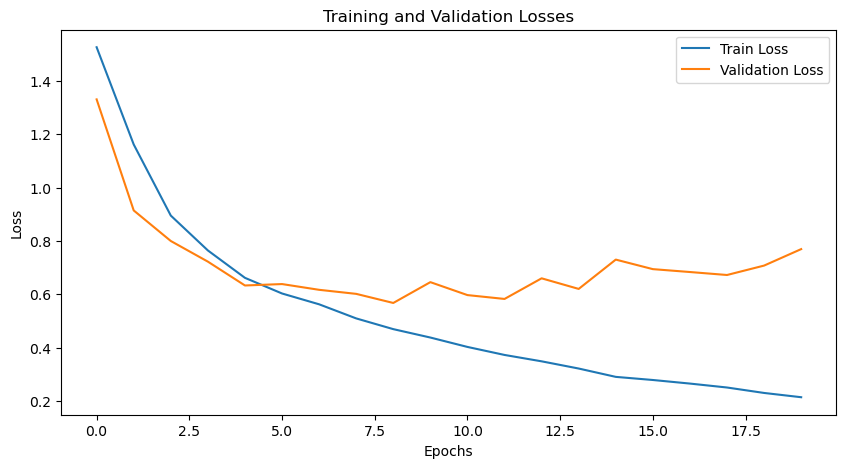

In [10]:
# Train model with training and validation data 

# Define hyperparameters and instantiate optimizer and loss function
epochs = 20
lr = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Train the model
train_losses, val_losses = train(model, train_dl, val_dl, epochs, optimizer, loss_func, device)

# Plot training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)


In [93]:
# Custom Dataset class for test data
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

# Load test data
test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]

# Define transformations for test data
# @TODO check if data augmentation should be applied to test data 1:1 or adapated or not at all
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.1, contrast=0.3, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create test dataset and dataloader
test_dataset = TestDataset(test_files, transform=transform)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to make predictions
def predict(model, test_dl, device):
    model.eval()
    predictions = []
    image_paths = []
    with torch.no_grad():
        for images, paths in test_dl:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            image_paths.extend(paths)
    return predictions, image_paths

# Make predictions on the test data
predictions, image_paths = predict(model, test_dl, device)

# Map predictions to emotion labels
id_to_emotion = {idx: emotion for idx, emotion in enumerate(emotions)}
predicted_emotions = [id_to_emotion[pred] for pred in predictions]

# Create submission.csv
import csv

with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id', 'emotions'])
    for img_path, emotion in zip(image_paths, predicted_emotions):
        img_id = os.path.basename(img_path)
        writer.writerow([img_id, emotion])

print("Predictions saved to submission.csv")


Predictions saved to submission.csv


In [ ]:
# TODO
# - find best combination of Batch size and learning rate (use learning rate finder)
# - adapt data augmentation 
# - clarify if data augmentation should 1:1 be applied on test data
# - Try different pretrained Models (ViT, Regner, VGG)

In [ ]:
#Learnings
#dont use image rotation or flipping for images (decreases model performance)
#as not much data -> use small validation set split (10%)

Densenet 20 Layers (minimal data augmentation, test set 0.1)
Epoch [1/20], Train Loss: 1.3711, Val Loss: 0.9399, Val Accuracy: 0.6213
Epoch [2/20], Train Loss: 0.8206, Val Loss: 0.7060, Val Accuracy: 0.7387
Epoch [3/20], Train Loss: 0.5345, Val Loss: 0.5583, Val Accuracy: 0.8035
Epoch [4/20], Train Loss: 0.3550, Val Loss: 0.6557, Val Accuracy: 0.7805
Epoch [5/20], Train Loss: 0.2935, Val Loss: 0.8071, Val Accuracy: 0.7596
Epoch [6/20], Train Loss: 0.2319, Val Loss: 0.6506, Val Accuracy: 0.8244
Epoch [7/20], Train Loss: 0.0994, Val Loss: 0.6962, Val Accuracy: 0.8068
Epoch [8/20], Train Loss: 0.1281, Val Loss: 0.7187, Val Accuracy: 0.8057
Epoch [9/20], Train Loss: 0.0881, Val Loss: 0.7519, Val Accuracy: 0.8079
Epoch [10/20], Train Loss: 0.1245, Val Loss: 0.8045, Val Accuracy: 0.7958
Epoch [11/20], Train Loss: 0.0422, Val Loss: 0.7111, Val Accuracy: 0.8189
Epoch [12/20], Train Loss: 0.0306, Val Loss: 0.7629, Val Accuracy: 0.8101
Epoch [13/20], Train Loss: 0.0437, Val Loss: 0.8028, Val Accuracy: 0.8145
Epoch [14/20], Train Loss: 0.0405, Val Loss: 0.8452, Val Accuracy: 0.8068
Epoch [15/20], Train Loss: 0.0783, Val Loss: 0.8005, Val Accuracy: 0.8068
Epoch [16/20], Train Loss: 0.1120, Val Loss: 0.6439, Val Accuracy: 0.8397
Epoch [17/20], Train Loss: 0.0231, Val Loss: 0.6794, Val Accuracy: 0.8386
Epoch [18/20], Train Loss: 0.0209, Val Loss: 0.8262, Val Accuracy: 0.8222
Epoch [19/20], Train Loss: 0.0293, Val Loss: 0.8350, Val Accuracy: 0.8266
Epoch [20/20], Train Loss: 0.0896, Val Loss: 0.7768, Val Accuracy: 0.8255